In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mission1111/Mission/test/Pepper__bell___Bacterial_spot/f6a20939-1617-49f7-a7a4-1dde2020426b___JR_B.Spot_3365.jpg
/kaggle/input/mission1111/Mission/test/Pepper__bell___Bacterial_spot/d7ab068b-694f-4a0e-8e72-ad065d9e7022___NREC_B.Spot_1834.jpg
/kaggle/input/mission1111/Mission/test/Pepper__bell___Bacterial_spot/fd733c73-855b-49df-87cd-628bcd5e87a7___NREC_B.Spot_9240.jpg
/kaggle/input/mission1111/Mission/test/Pepper__bell___Bacterial_spot/648a0b23-8a55-4530-a0a0-b04882298d24___NREC_B.Spot_1839.jpg
/kaggle/input/mission1111/Mission/test/Pepper__bell___Bacterial_spot/3c237d3f-7242-4009-a08a-b4eb7cd662fc___NREC_B.Spot_1969.jpg
/kaggle/input/mission1111/Mission/test/Pepper__bell___Bacterial_spot/525555a6-c09c-4551-8b9d-d2a8050f474d___JR_B.Spot_3355.jpg
/kaggle/input/mission1111/Mission/test/Pepper__bell___Bacterial_spot/836b4b9e-85d5-47bc-ad93-9ab31b07be3d___JR_B.Spot_3361.jpg
/kaggle/input/mission1111/Mission/test/Pepper__bell___Bacterial_spot/ab5f2fed-0c46-46ad-b63a-86760db73e

In [2]:
# PyTorch core
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import cv2
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import random
import shutil
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


✅ Train folder: /kaggle/input/mission1111/Mission/train
✅ Test folder: /kaggle/input/mission1111/Mission/test

📂 TRAIN DATASET SUMMARY
  - Pepper__bell___Bacterial_spot: 697 images
  - Pepper__bell___healthy: 1034 images
  - Potato___Early_blight: 700 images
  - Potato___Late_blight: 700 images
  - Potato___healthy: 106 images
  - Tomato_Bacterial_spot: 1488 images
  - Tomato_Early_blight: 700 images
  - Tomato_Late_blight: 1336 images
  - Tomato_Leaf_Mold: 666 images
  - Tomato_Septoria_leaf_spot: 1239 images
  - Tomato_Spider_mites_Two_spotted_spider_mite: 1173 images
  - Tomato__Target_Spot: 982 images
  - Tomato__Tomato_YellowLeaf__Curl_Virus: 2245 images
  - Tomato__Tomato_mosaic_virus: 261 images
  - Tomato_healthy: 1113 images
👉 Total images in train: 14440

📂 TEST DATASET SUMMARY
  - Pepper__bell___Bacterial_spot: 300 images
  - Pepper__bell___healthy: 444 images
  - Potato___Early_blight: 300 images
  - Potato___Late_blight: 300 images
  - Potato___healthy: 46 images
  - Tomat

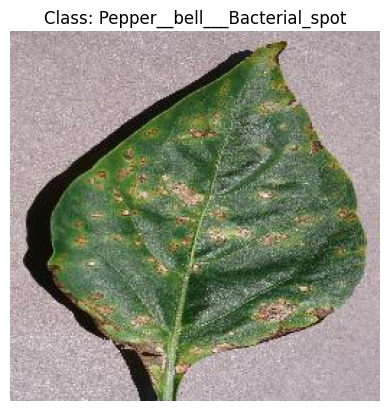

In [3]:
dataset_root = Path("/kaggle/input/mission1111/Mission")

# Train and Test directories
train_dir = dataset_root / "train"
test_dir  = dataset_root / "test"

print("✅ Train folder:", train_dir)
print("✅ Test folder:", test_dir)

# Function to list classes and counts
def dataset_summary(split_dir):
    print(f"\n📂 {split_dir.name.upper()} DATASET SUMMARY")
    total_images = 0
    for class_dir in sorted(os.listdir(split_dir)):
        class_path = split_dir / class_dir
        if class_path.is_dir():
            count = len(list(class_path.glob("*.jpg"))) + len(list(class_path.glob("*.png")))
            total_images += count
            print(f"  - {class_dir}: {count} images")
    print(f"👉 Total images in {split_dir.name}: {total_images}")
    return total_images

# Print dataset details
total_train = dataset_summary(train_dir)
total_test  = dataset_summary(test_dir)

print("\n📊 OVERALL DATASET SUMMARY")
print(f"  - Total Train Images: {total_train}")
print(f"  - Total Test Images : {total_test}")
print(f"  - Grand Total       : {total_train + total_test}")

# Show one sample image from train
sample_class = sorted(os.listdir(train_dir))[0]  # pick first class alphabetically
sample_path = list((train_dir / sample_class).glob("*.jpg"))[0]

img = cv2.imread(str(sample_path))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title(f"Class: {sample_class}")
plt.axis("off")
plt.show()


In [4]:
# -------------------------------
#  DeepLabV3+ for background removal
# -------------------------------
deeplab = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

bg_preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
def remove_background(img_pil):
    """Remove background using DeepLabV3+ (class 21 = plant/vegetation in COCO)."""
    input_tensor = bg_preprocess(img_pil).unsqueeze(0)
    with torch.no_grad():
        output = deeplab(input_tensor)['out'][0]
    mask = output.argmax(0).byte().cpu().numpy()
    leaf_mask = (mask != 0).astype(np.uint8) * 255
    img_cv = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    leaf_only = cv2.bitwise_and(img_cv, img_cv, mask=leaf_mask)
    return leaf_only

# -------------------------------
# 2. Custom preprocessing: Gaussian + CLAHE + resize + normalize
# -------------------------------
def custom_preprocess(img_bgr, size=(256,256)):
    # Noise cancellation
    img = cv2.GaussianBlur(img_bgr, (3,3), 0)
    
    # Contrast enhancement (CLAHE)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    # Resize
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    
    # Normalize to [0,1]
    img = img.astype(np.float32) / 255.0
    return img


# -------------------------------
# 3. Albumentations transforms (augment only training)
# -------------------------------
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=25, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),  # <--- ADD THIS
    ToTensorV2()
])

test_aug = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),  # <--- ADD THIS
    ToTensorV2()
])


# -------------------------------
# 4. Dataset Class
# -------------------------------
class LeafDataset(Dataset):
    def __init__(self, root_dir, transform=None, use_deeplab=False):
        self.root_dir = Path(root_dir)
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.samples = []
        self.transform = transform
        self.use_deeplab = use_deeplab

        for class_idx, class_name in enumerate(self.classes):
            for img_path in (self.root_dir / class_name).glob("*.jpg"):
                self.samples.append((img_path, class_idx))
            for img_path in (self.root_dir / class_name).glob("*.png"):
                self.samples.append((img_path, class_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        # Load image
        img_pil = Image.open(img_path).convert("RGB")
        img_cv = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

        # 1. Optional background removal
        if self.use_deeplab:
            img_cv = remove_background(img_pil)

        # 2. Apply custom preprocessing (Gaussian + CLAHE + resize + normalize)
        img_cv = custom_preprocess(img_cv)

        # Albumentations expects numpy RGB image
        img = cv2.cvtColor((img_cv*255).astype(np.uint8), cv2.COLOR_BGR2RGB)

        # 3. Albumentations augment/transform
        if self.transform:
            img = self.transform(image=img)["image"]

        return img, label

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 210MB/s] 


In [5]:

train_dir = "/kaggle/input/mission1111/Mission/train"
test_dir  = "/kaggle/input/mission1111/Mission/test"

# Train dataset (with augmentation)
train_dataset = LeafDataset(train_dir, transform=train_aug, use_deeplab=False)
test_dataset  = LeafDataset(test_dir,  transform=test_aug,  use_deeplab=False)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

# Check sample
images, labels = next(iter(train_loader))
print("Batch image tensor shape:", images.shape)
print("Batch label tensor shape:", labels.shape)


Batch image tensor shape: torch.Size([32, 3, 256, 256])
Batch label tensor shape: torch.Size([32])


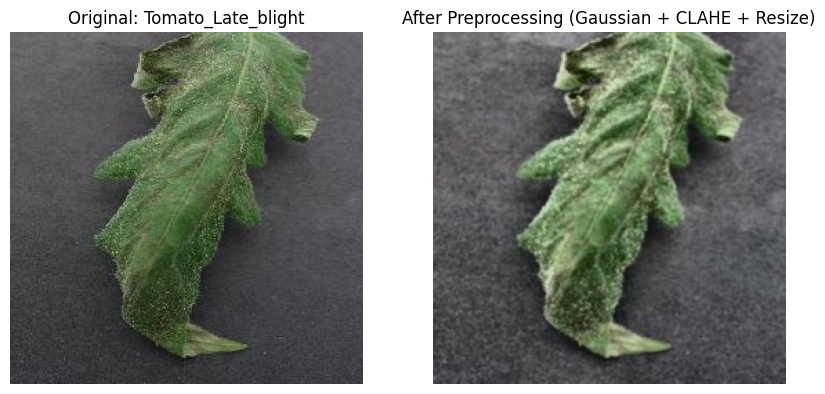

In [6]:
# Pick a random sample from train dataset
idx = random.randint(0, len(train_dataset) - 1)
img_path, label = train_dataset.samples[idx]

# Load original image
orig = cv2.imread(str(img_path))
orig_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

# Apply preprocessing (without augmentation)
preproc_img = custom_preprocess(orig)
preproc_rgb = cv2.cvtColor((preproc_img*255).astype(np.uint8), cv2.COLOR_BGR2RGB)

# Plot original vs preprocessed
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(orig_rgb)
plt.title(f"Original: {train_dataset.classes[label]}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(preproc_rgb)
plt.title("After Preprocessing (Gaussian + CLAHE + Resize)")
plt.axis("off")

plt.show()

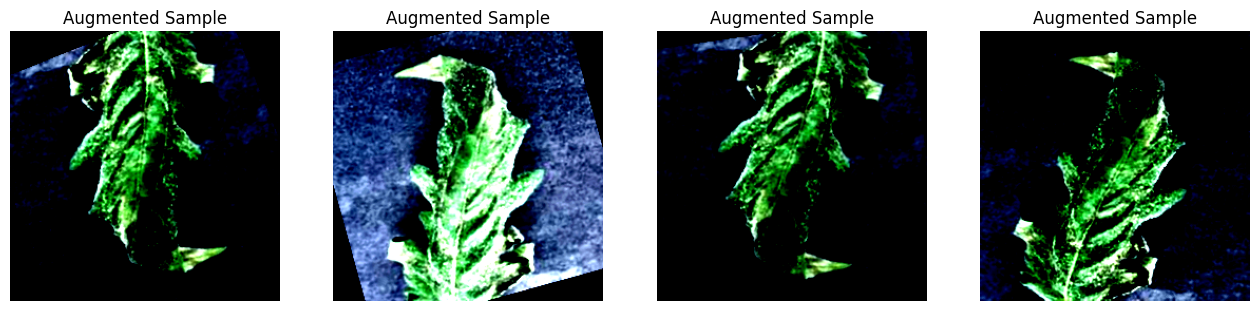

In [7]:
    # Apply augmentation multiple times to see variations
    fig, axes = plt.subplots(1, 4, figsize=(16,4))

    for i in range(4):
        aug_img = train_aug(image=preproc_rgb)["image"]
        aug_img_np = aug_img.permute(1,2,0).cpu().numpy()
        axes[i].imshow(aug_img_np)  # ✅ direct show
        axes[i].set_title("Augmented Sample")
        axes[i].axis("off")
    plt.show()


In [8]:
class PlantVillageCNN(nn.Module):
    def __init__(self, num_classes=38):
        super(PlantVillageCNN, self).__init__()
        
        # Convolution Layer 1 (in_channels=3 for RGB)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)  # padding=1 → same padding
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 → 128
        
        # Convolution Layer 2
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 128 → 64 → 32 → 16
        
        # Convolution Layer 3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 16 → 8 → 4
        
        # Fully Connected Layer
        self.fc1 = nn.Linear(32 * 32 * 32, 512)  # adjust size after pooling
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # Conv Layer 1
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        # Conv Layer 2
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        # Conv Layer 3
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        
        # Flatten
        x = torch.flatten(x, 1)  # (batch_size, features)
        
        # Fully Connected
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # logits
        
        return x

# Test the model
model = PlantVillageCNN(num_classes=38)
print(model)


PlantVillageCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=38, bias=True)
)


In [9]:
def forward(self, x):
    x = F.relu(self.conv1(x)); x = self.pool1(x)
    x = F.relu(self.conv2(x)); x = self.pool2(x)
    x = F.relu(self.conv3(x)); x = self.pool3(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    return self.fc2(x)


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PlantVillageCNN(num_classes=38).to(device)

criterion = nn.CrossEntropyLoss()        # ✅ classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [11]:
model = model.to(device)


In [12]:
# ✅ Device check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move model to GPU
model = model.to(device)

num_epochs = 40
best_acc = 0.0   # track best test accuracy
best_epoch = 0   # track which epoch was best

for epoch in range(num_epochs):
    # ---------------- TRAIN ----------------
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Stats
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    
    # ---------------- EVAL ----------------
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Test]", leave=False):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_loss /= len(test_loader)
    test_acc = 100 * correct / total
    
    # ---------------- LOGGING ----------------
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    
    # ---------------- SAVE BEST MODEL ----------------
    if test_acc > best_acc:
        best_acc = test_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "best_plantvillage_cnn.pth")
        print(f"💾 Saved new best model at epoch {best_epoch} with Test Acc: {best_acc:.2f}%")

print(f"\n✅ Training complete! Best epoch = {best_epoch}, Best Test Acc = {best_acc:.2f}%")

# ✅ After training, check GPU usage
!nvidia-smi


Using device: cuda


Epoch [1/40] Train Loss: 1.2903, Train Acc: 58.12% | Test Loss: 0.8313, Test Acc: 71.66%
💾 Saved new best model at epoch 1 with Test Acc: 71.66%


Epoch [2/40] Train Loss: 0.6066, Train Acc: 79.76% | Test Loss: 0.4432, Test Acc: 85.39%
💾 Saved new best model at epoch 2 with Test Acc: 85.39%


Epoch [3/40] Train Loss: 0.4323, Train Acc: 85.51% | Test Loss: 0.3186, Test Acc: 89.20%
💾 Saved new best model at epoch 3 with Test Acc: 89.20%


Epoch [4/40] Train Loss: 0.3514, Train Acc: 88.05% | Test Loss: 0.2945, Test Acc: 89.82%
💾 Saved new best model at epoch 4 with Test Acc: 89.82%


Epoch [5/40] Train Loss: 0.2927, Train Acc: 90.13% | Test Loss: 0.2590, Test Acc: 91.24%
💾 Saved new best model at epoch 5 with Test Acc: 91.24%


Epoch [6/40] Train Loss: 0.2567, Train Acc: 91.37% | Test Loss: 0.2875, Test Acc: 90.67%


Epoch [7/40] Train Loss: 0.2331, Train Acc: 92.16% | Test Loss: 0.2054, Test Acc: 92.53%
💾 Saved new best model at epoch 7 with Test Acc: 92.53%


Epoch [8/40] Train Loss: 0.2117, Train Acc: 92.83% | Test Loss: 0.2812, Test Acc: 90.99%


Epoch [9/40] Train Loss: 0.1927, Train Acc: 93.46% | Test Loss: 0.2114, Test Acc: 92.88%
💾 Saved new best model at epoch 9 with Test Acc: 92.88%


Epoch [10/40] Train Loss: 0.1797, Train Acc: 94.06% | Test Loss: 0.1974, Test Acc: 93.64%
💾 Saved new best model at epoch 10 with Test Acc: 93.64%


Epoch [11/40] Train Loss: 0.1669, Train Acc: 94.40% | Test Loss: 0.2160, Test Acc: 93.11%


Epoch [12/40] Train Loss: 0.1740, Train Acc: 94.34% | Test Loss: 0.2652, Test Acc: 91.51%


Epoch [13/40] Train Loss: 0.1498, Train Acc: 94.97% | Test Loss: 0.2251, Test Acc: 93.38%


Epoch [14/40] Train Loss: 0.1340, Train Acc: 95.64% | Test Loss: 0.2021, Test Acc: 93.96%
💾 Saved new best model at epoch 14 with Test Acc: 93.96%


Epoch [15/40] Train Loss: 0.1580, Train Acc: 94.69% | Test Loss: 0.1727, Test Acc: 94.59%
💾 Saved new best model at epoch 15 with Test Acc: 94.59%


Epoch [16/40] Train Loss: 0.1166, Train Acc: 96.22% | Test Loss: 0.1344, Test Acc: 95.67%
💾 Saved new best model at epoch 16 with Test Acc: 95.67%


Epoch [17/40] Train Loss: 0.1278, Train Acc: 95.92% | Test Loss: 0.1458, Test Acc: 95.48%


Epoch [18/40] Train Loss: 0.1160, Train Acc: 96.14% | Test Loss: 0.1722, Test Acc: 94.58%


Epoch [19/40] Train Loss: 0.1213, Train Acc: 96.19% | Test Loss: 0.2211, Test Acc: 93.37%


Epoch [20/40] Train Loss: 0.1121, Train Acc: 96.39% | Test Loss: 0.1391, Test Acc: 95.26%


Epoch [21/40] Train Loss: 0.1042, Train Acc: 96.66% | Test Loss: 0.1943, Test Acc: 94.53%


Epoch [22/40] Train Loss: 0.1081, Train Acc: 96.46% | Test Loss: 0.1667, Test Acc: 94.61%


Epoch [23/40] Train Loss: 0.0985, Train Acc: 96.64% | Test Loss: 0.1945, Test Acc: 94.54%


Epoch [24/40] Train Loss: 0.1187, Train Acc: 96.41% | Test Loss: 0.1296, Test Acc: 95.80%
💾 Saved new best model at epoch 24 with Test Acc: 95.80%


Epoch [25/40] Train Loss: 0.0878, Train Acc: 97.06% | Test Loss: 0.2026, Test Acc: 94.66%


Epoch [26/40] Train Loss: 0.1113, Train Acc: 96.40% | Test Loss: 0.1728, Test Acc: 95.53%


Epoch [27/40] Train Loss: 0.1018, Train Acc: 96.81% | Test Loss: 0.1381, Test Acc: 96.11%
💾 Saved new best model at epoch 27 with Test Acc: 96.11%


Epoch [28/40] Train Loss: 0.0936, Train Acc: 96.96% | Test Loss: 0.1802, Test Acc: 94.88%


Epoch [29/40] Train Loss: 0.1085, Train Acc: 96.64% | Test Loss: 0.3803, Test Acc: 89.95%


Epoch [30/40] Train Loss: 0.0884, Train Acc: 97.21% | Test Loss: 0.1659, Test Acc: 95.05%


Epoch [31/40] Train Loss: 0.0873, Train Acc: 97.25% | Test Loss: 0.1763, Test Acc: 95.08%


Epoch [32/40] Train Loss: 0.0795, Train Acc: 97.38% | Test Loss: 0.1715, Test Acc: 95.42%


Epoch [33/40] Train Loss: 0.0821, Train Acc: 97.23% | Test Loss: 0.1601, Test Acc: 95.48%


Epoch [34/40] Train Loss: 0.0891, Train Acc: 97.22% | Test Loss: 0.1453, Test Acc: 95.63%


Epoch [35/40] Train Loss: 0.0739, Train Acc: 97.66% | Test Loss: 0.1912, Test Acc: 94.51%


Epoch [36/40] Train Loss: 0.0782, Train Acc: 97.45% | Test Loss: 0.1392, Test Acc: 95.98%


Epoch [37/40] Train Loss: 0.0862, Train Acc: 97.30% | Test Loss: 0.1472, Test Acc: 96.17%
💾 Saved new best model at epoch 37 with Test Acc: 96.17%


Epoch [38/40] Train Loss: 0.0760, Train Acc: 97.69% | Test Loss: 0.1899, Test Acc: 95.06%


Epoch [39/40] Train Loss: 0.0632, Train Acc: 98.00% | Test Loss: 0.1889, Test Acc: 95.19%


Epoch [40/40] Train Loss: 0.0713, Train Acc: 97.78% | Test Loss: 0.1714, Test Acc: 95.42%

✅ Training complete! Best epoch = 37, Best Test Acc = 96.17%
Wed Sep 17 21:45:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P0             32W /  250W |    2837MiB /  16384MiB |     10%    

📊 Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.95      0.97      0.96       300
                     Pepper__bell___healthy       1.00      0.95      0.97       444
                      Potato___Early_blight       0.95      0.99      0.97       300
                       Potato___Late_blight       0.92      0.94      0.93       300
                           Potato___healthy       0.76      0.98      0.86        46
                      Tomato_Bacterial_spot       0.98      0.97      0.97       639
                        Tomato_Early_blight       0.93      0.84      0.88       300
                         Tomato_Late_blight       0.98      0.91      0.94       572
                           Tomato_Leaf_Mold       0.96      0.93      0.95       286
                  Tomato_Septoria_leaf_spot       0.97      0.91      0.94       532
Tomato_Spider_mites_Two_spotted_spider_

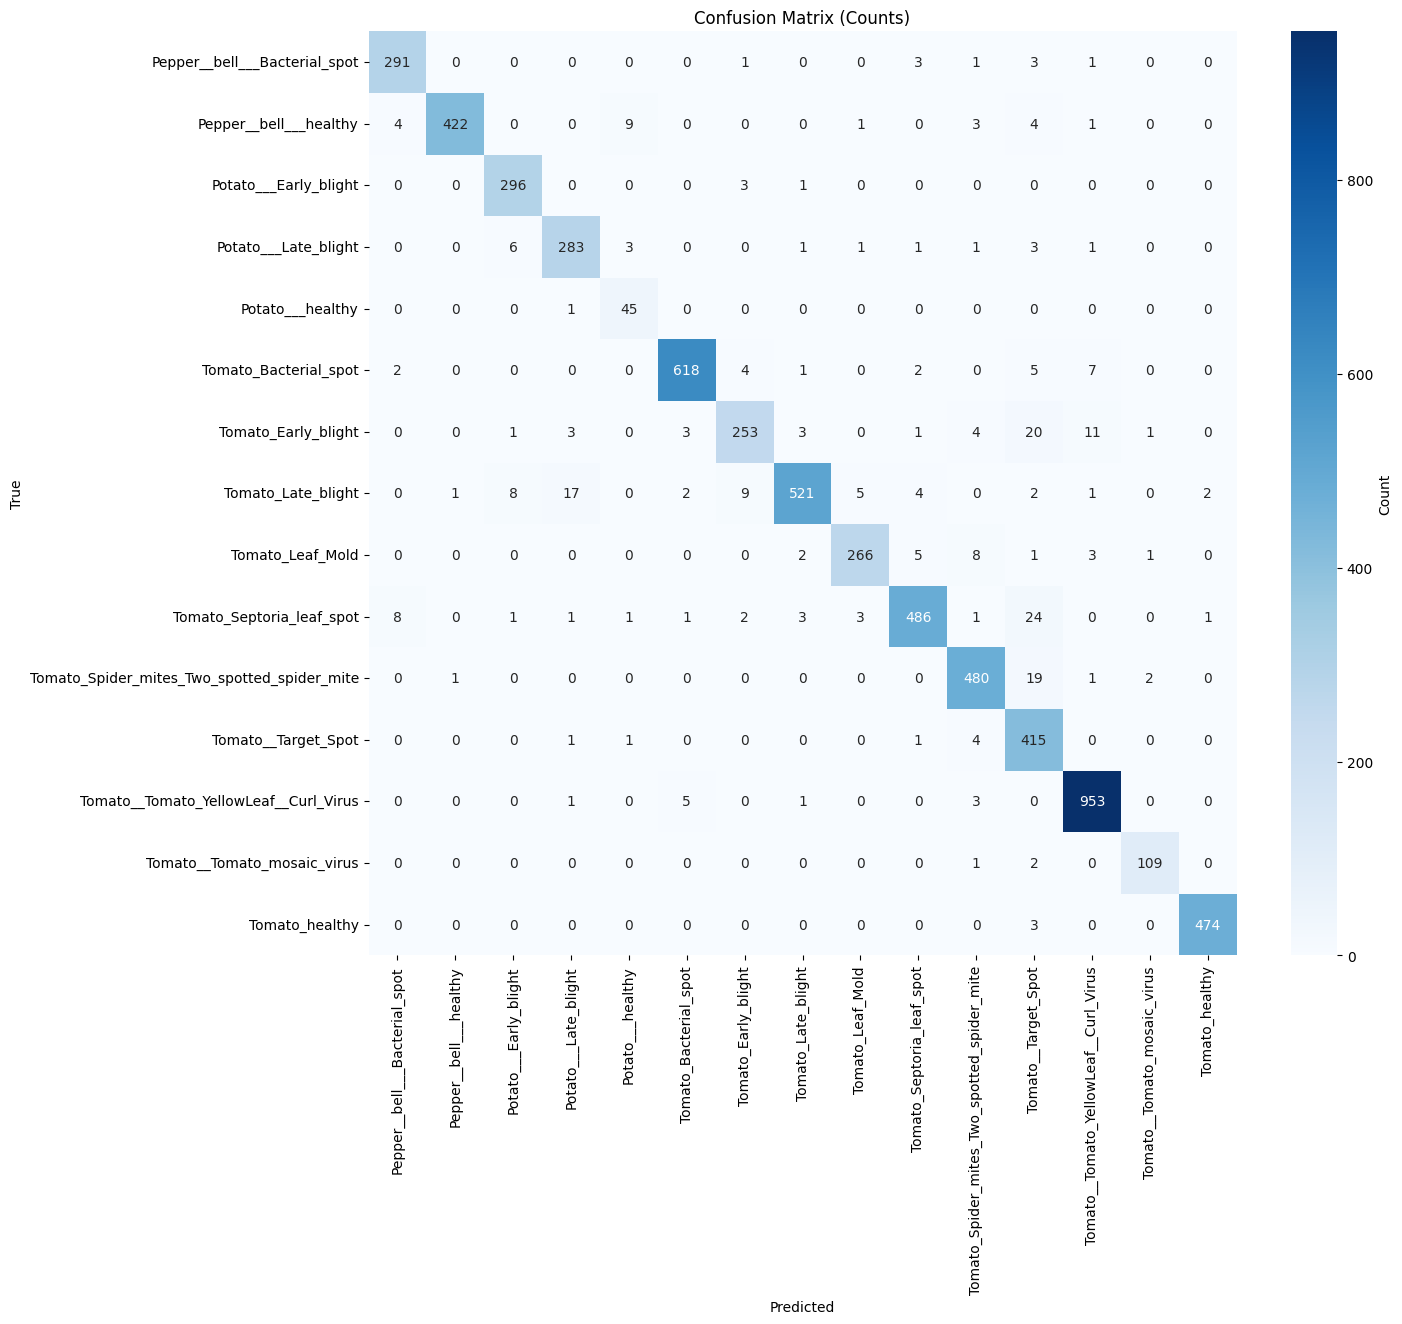

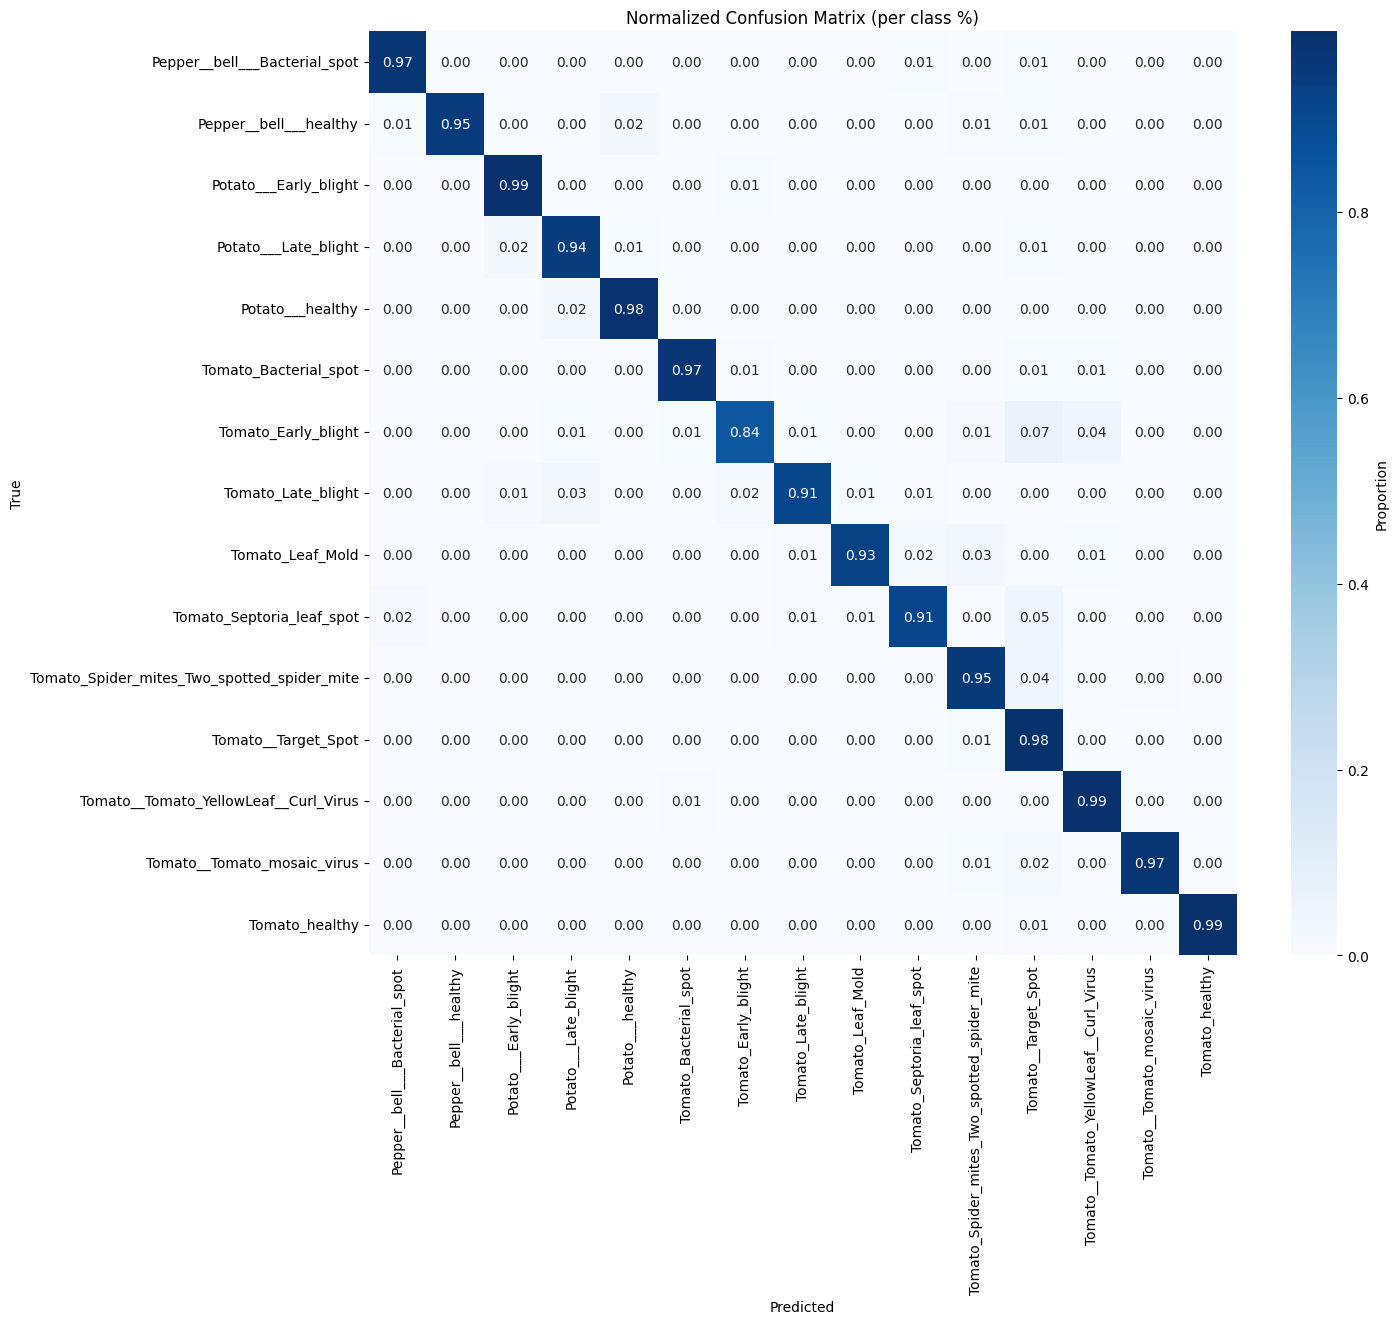

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# EVALUATE FULL TEST SET
# -------------------------------
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# ✅ Class names (same order as dataset)
class_names = test_dataset.classes

# 📊 Classification Report
print("📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# 📊 Confusion Matrix (raw counts)
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(14,12))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Counts)")
plt.show()

# 📊 Normalized Confusion Matrix (per-class %)
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14,12))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Proportion'})
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (per class %)")
plt.show()
